# Tracé des RVI
Le RVI est un indicateur de végétation calculé à partir des données SAR. Le but de ce code est de montrer sa cohérence avec l'indicateur optique de couverture végétale FCOVER.

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm

import sentry

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
target = "../data/Barro-Alto"

Le répertoire source contient la zone d'intérêt, les fichiers SAFE .zip téléchargés et un fichier json : "geozone.json" qui décrit les éléments de décompression et la partie à extraire.

In [4]:
zone = sentry.getzone(target)
zone

{'name': 'Barro Alto Nickel Mine (Brasil)',
 'bbox': [-15.12, -49.06, -15.02, -48.92],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD/Barro-Alto',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Barro-Alto'}

La cellule suivante doit être décommentée si vous avez des données brutes et que vous souhaitez les recharger. Sinon, le code utilisera les données préchargées stockées dans les fichiers CSV.

In [5]:
#sentry.dataset.rvicompute(zone,renew=True)

In [6]:
R = sentry.dataset.rvi(zone)

In [7]:
R

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,ZIPFILE
DATE,,,,,,,,
2019-06-24,2.024882,0.016118,17.564305,15.647990,-1,0.059395,0.987299,S1A_IW_GRDH_1SDV_20190624T085316_20190624T0853...
2019-08-11,2.023578,0.015742,17.542523,15.628676,-1,0.059485,0.988373,S1A_IW_GRDH_1SDV_20190811T085319_20190811T0853...
2019-08-30,2.017972,0.012146,24.283702,21.349498,-1,0.348239,-1.003929,S1A_IW_GRDH_1SDV_20190830T084511_20190830T0845...
2019-09-16,2.022600,0.015615,17.640682,15.716034,-1,0.059595,0.987222,S1A_IW_GRDH_1SDV_20190916T085321_20190916T0853...
2019-09-23,2.017765,0.012284,24.152574,21.234440,-1,0.347998,-1.002553,S1A_IW_GRDH_1SDV_20190923T084512_20190923T0845...
...,...,...,...,...,...,...,...,...
2021-02-20,2.023011,0.015419,24.389038,21.441917,-1,0.348156,-1.002196,S1A_IW_GRDH_1SDV_20210220T084515_20210220T0845...
2021-02-25,2.028751,0.018692,17.724768,15.791391,-1,0.059773,0.987176,S1A_IW_GRDH_1SDV_20210225T085324_20210225T0853...
2021-03-04,2.022170,0.013826,24.543407,21.577595,-1,0.348241,-1.002417,S1A_IW_GRDH_1SDV_20210304T084515_20210304T0845...


DLAT et DLON correspondent aux coordonnées du vecteur topographique reliant le milieu de l'image de 250 km de large et 170 km de long acquise par le satellite et le centre de la zone d'intérêt.

<AxesSubplot:xlabel='DATE'>

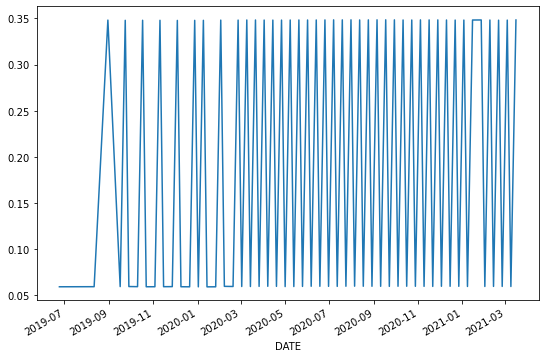

In [8]:
R['DLAT'].plot()

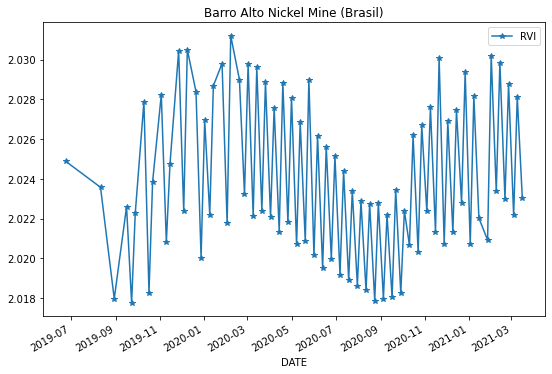

In [9]:
R['RVI'].plot(style='-*',legend=True)
plt.title(zone['name']);

In [10]:
rvi = R['RVI']

## Récupération de FCOVER

La ligne suivante est à décommenter si vous souhaitez recharger des données depuis une source nouvellement acquise.

In [11]:
# sentry.dataset.glscompute(zone,'FCOVER')

In [12]:
F = sentry.gls(zone,'FCOVER')

In [13]:
fcover = F['FCOVER']

In [14]:
rmse = F['RMSE']

## On fait un affichage superposé des deux indices.

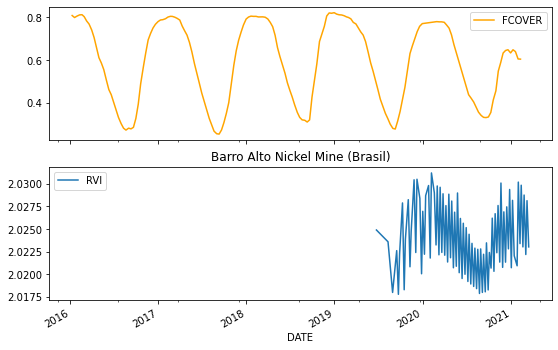

In [15]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
plt.title(zone['name'])
fcover.plot(ax=ax1,color='orange')
rvi.plot(ax=ax2)
ax1.legend(['FCOVER'])
ax2.legend(['RVI']);

## Apprentissage de la transformation du RVI
On cherche à recoller avec FCOVER.
Il faut prendre en compte l'angle de balayage.

In [16]:
from scipy.interpolate import interp1d

In [17]:
x = rvi.index
ry0 = rvi.values
ry = (ry0-min(ry0))/((max(ry0)-min(ry0)))

In [18]:
Fc = interp1d(pd.to_numeric(fcover.index),fcover.values,fill_value="extrapolate")

In [19]:
fy = Fc(pd.to_numeric(x))

In [20]:
Fe = interp1d(pd.to_numeric(rmse.index),rmse.values,fill_value="extrapolate")
fe = Fe(pd.to_numeric(x))

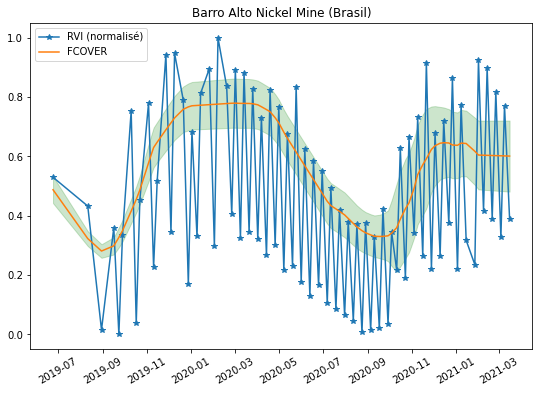

In [21]:
fig,ax = plt.subplots()
plt.plot(x,ry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['RVI (normalisé)','FCOVER'])
plt.title(zone['name']);

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
M = R[['RVI','INCIDENCE','ELEVATION','DLAT','DLON']].copy()
M['FCOVER'] = fy

J'ai testé si l'incidence et l'élévation avaient encore une importance, mais ce n'est pas le cas car des informations ont été prises en compte lors de la calibration du capteur.

In [24]:
res = smf.ols('FCOVER ~ RVI + DLAT + DLON', data=M).fit()

In [25]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 FCOVER   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     57.47
Date:                Mon, 22 Mar 2021   Prob (F-statistic):           2.69e-20
Time:                        18:13:23   Log-Likelihood:                 87.548
No. Observations:                  88   AIC:                            -167.1
Df Residuals:                      84   BIC:                            -157.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.5113     14.987     -5.039      0.000    -105.314     -45.709
RVI           53.5439      4.328     12.373      0.000      44.938      62.150
DLAT        -159.0630     55.027     -2.891      0.005    -268.490     -49.636
DLON         -23.2362      7.980     -2.912      0.005     -39.105      -7.367
==============================================================================
Omnibus:                        0.410   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.574
Skew:                          -0.096   Prob(JB):                        0.751
Kurtosis:                       2.654   Cond. No.                     1.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

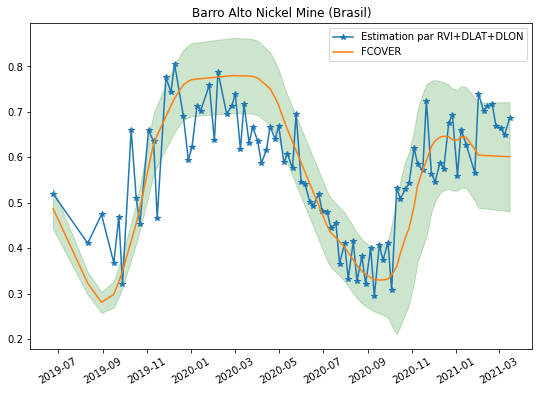

In [26]:
fig,ax = plt.subplots()
plt.plot(x,res.fittedvalues,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['Estimation par RVI+DLAT+DLON','FCOVER'])
plt.title(zone['name']);

##  Corrélations

In [27]:
from scipy.stats import kendalltau

In [28]:
tau0,pval0 = kendalltau(fy,ry0)
print("Corrélation entre FCOVER et RVI (tau,pValue):")
(tau0,pval0)

Corrélation entre FCOVER et RVI (tau,pValue):


(0.31818181818181823, 1.1346256977424921e-05)

In [29]:
tau,pval = kendalltau(fy,res.fittedvalues) 
print("Corrélation entre FCOVER et l'estimation de FCOVER par RVI, DLAT et DLON:")
(tau,pval)

Corrélation entre FCOVER et l'estimation de FCOVER par RVI, DLAT et DLON:


(0.5783699059561129, 1.4697229926158492e-15)

## Etude d'une correction de RVI par DLAT et DLON.
On cherche à éviter d'utiliser FCOVER pour avoir un calcul intrinsèque.

L'idée est de minimiser Delta_RVI par une correction du type RVI + alpha*DLAT + beta*DLON.

In [30]:
R['DRVI'] = rvi.diff()
R['DDLAT'] = R['DLAT'].diff()
R['DDLON'] = R['DLON'].diff()
resi = smf.ols('DRVI ~ DDLAT + DDLON -1',data=R).fit()
resi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   DRVI   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              468.7
Date:                Mon, 22 Mar 2021   Prob (F-statistic):                    1.23e-46
Time:                        18:13:41   Log-Likelihood:                          427.92
No. Observations:                  87   AIC:                                     -851.8
Df Residuals:                      85   BIC:                                     -846.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DDLAT          0.3373      1.339      0.252      0.802      -2.324       2.999
DDLON          0.0520      0.194      0.268      0.789      -0.334       0.438
==============================================================================
Omnibus:                       14.667   Durbin-Watson:                   3.098
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.060
Skew:                           0.875   Prob(JB):                     0.000197
Kurtosis:                       4.282   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

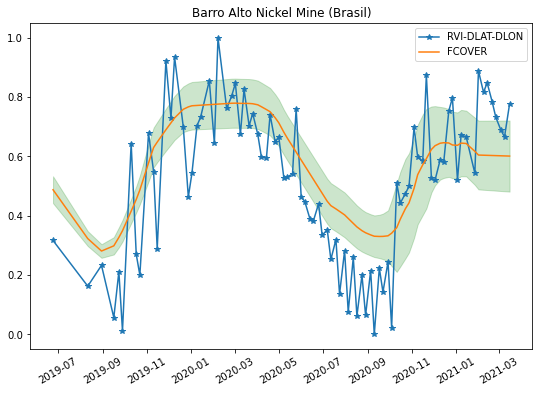

In [33]:
fig,ax = plt.subplots()
dry0 = rvi - R[['DLAT','DLON']].dot(resi.params.values)
dry = (dry0-dry0.min())/(dry0.max()-dry0.min())
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['RVI-DLAT-DLON','FCOVER'])
plt.title(zone['name']);

In [34]:
tau1,pval1 = kendalltau(fy,dry0)
print("Corrélation entre FCOVER et le RVI corrigé par DLAT et DLON :")
(tau1,pval1)

Corrélation entre FCOVER et le RVI corrigé par DLAT et DLON :


(0.5679205851619644, 4.677304435558995e-15)

## Lissage
Pour essayer de compenser l'effet de moyenne de FCOVER, on combine les mesures de RVI deux par deux.

(0.6565826330532213, 5.756589280633659e-19)

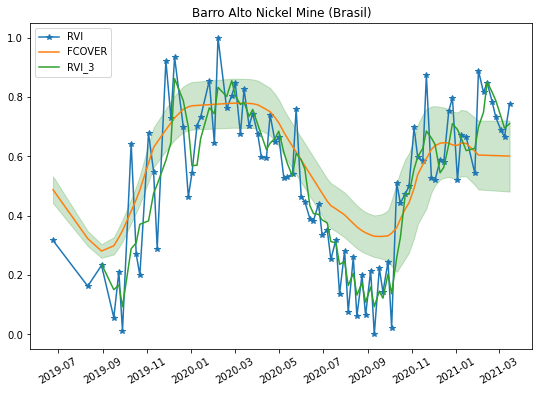

In [53]:
n=3
rdry = dry.rolling(window=n).mean()

fig,ax = plt.subplots()
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.plot(x,rdry)
plt.xticks(rotation=30)
ax.legend(['RVI','FCOVER','RVI_3'])
plt.title(zone['name']);

tau,pvalue = kendalltau(fy[n:],rdry[n:])
tau,pvalue

(0.6565826330532213, 5.756589280633659e-19)

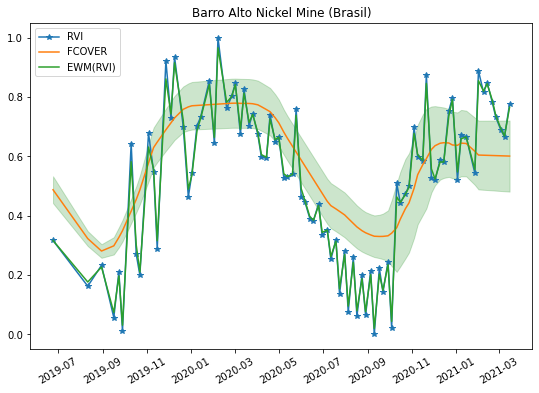

In [50]:
edry = dry.ewm(alpha=0.9).mean()

ig,ax = plt.subplots()
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.plot(x,edry)
plt.xticks(rotation=30)
ax.legend(['RVI','FCOVER','EWM(RVI)'])
plt.title(zone['name']);

tau,pvalue = kendalltau(fy[n:],rdry[n:])
tau,pvalue

## Chargement de NDVI
Le chargement d'autres indicateurs GLS utilise le mêm code.

Décommenter la cellule suivante pour recharger de nouvelles données.

In [ ]:
#sentry.dataset.glscompute(zone,'NDVI')

In [ ]:
NDVI = sentry.gls(zone,'NDVI')

In [ ]:
ndvi = NDVI['NDVI']

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
plt.title(zone['name'])
fcover.plot(ax=ax1)
rvi.plot(ax=ax2)
ndvi.plot(ax=ax3)
ax1.legend(['FCOVER'])
ax2.legend(['RVI'])
ax3.legend(['NDVI']);

## Approche différentielle

In [ ]:
drvi